In [189]:
import pymysql
import pymysql.cursors
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
#connect my database

In [191]:
mydb = pymysql.connect(
    host='127.0.0.1',
    port=3306,
    user='root',
    passwd='',
    db='action'
    )

In [192]:
#merge table information

In [ ]:
cursor=mydb.cursor()
all_info_table_train='CREATE TABLE all_info_table_train AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-02-01 00:00:00" AND "2018-04-10 00:00:00"'
cursor.execute(all_info_table_train)
myresult_train=cursor.fetchall()

In [ ]:
cursor2=mydb.cursor()
all_info_table_test='CREATE TABLE all_info_table_test AS\
                SELECT P.cate,A.user_id,A.sku_id,A.action_time,P.brand,P.shop_id,A.type,U.sex,U.age,U.user_lv_cd,U.city_level\
                FROM action AS A\
                JOIN product AS P ON P.sku_id=A.sku_id\
                JOIN user AS U ON U.user_id=A.user_id\
                WHERE A.type=2 AND A.action_time BETWEEN "2018-04-10 00:00:00" AND "2018-04-16 00:00:00"'
cursor2.execute(all_info_table_test)
myresult_test=cursor.fetchall()

In [ ]:
cursor.close()

In [5]:
top10_all_info_table_train='SELECT *\
                            FROM all_info_table_train\
                            limit 10'
sql_top_10_all_info_table_train=pd.read_sql_query(top10_all_info_table_train,mydb)
print(sql_top_10_all_info_table_train)

   cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   660257  282037  2018-02-08 15:05:37.0   4854     5338     2  1.0   
1    79  1008776   31647  2018-03-02 01:02:08.0  10511     9665     2  0.0   
2    79  1569797  141162  2018-02-06 22:32:30.0   4854       79     2  1.0   
3    79  1066676  102904  2018-03-08 10:22:09.0   1226     7129     2  1.0   
4    79  1314628  102417  2018-02-05 11:47:45.0   5700     1553     2  1.0   
5    79   982912  264665  2018-02-18 16:19:44.0   1898     1182     2  0.0   
6    79   260858  307497  2018-02-01 19:29:26.0   5206     9665     2  0.0   
7    79  1123179  274889  2018-03-18 16:26:49.0   2564     6710     2  1.0   
8    79   148013   47151  2018-02-21 18:48:56.0   2564     1095     2  1.0   
9    79   399810  270064  2018-03-04 11:47:11.0   4361     5896     2  1.0   

   age  user_lv_cd city_level  
0  5.0           1             
1  6.0           7        4.0  
2  5.0           5        4.0  
3  6.0       

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from copy import deepcopy
import csv
import os

In [194]:
#load dataset

In [195]:
train_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_train.csv')
test_df=pd.read_csv('/Users/charles/Desktop/consumer/all_info_table_test.csv')

In [9]:
train_df.head(5)

cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   660257  282037  2018-02-08 15:05:37.0   4854     5338     2  1.0   
1    79  1008776   31647  2018-03-02 01:02:08.0  10511     9665     2  0.0   
2    79  1569797  141162  2018-02-06 22:32:30.0   4854       79     2  1.0   
3    79  1066676  102904  2018-03-08 10:22:09.0   1226     7129     2  1.0   
4    79  1314628  102417  2018-02-05 11:47:45.0   5700     1553     2  1.0   

   age  user_lv_cd  city_level  
0  5.0           1         NaN  
1  6.0           7         4.0  
2  5.0           5         4.0  
3  6.0           7         1.0  
4  5.0           5         1.0

In [10]:
test_df.head(5)

cate  user_id  sku_id            action_time  brand  shop_id  type  sex  \
0    79   537520   58984  2018-04-14 18:44:53.0   2564     1095     2  NaN   
1    19  1195693  261922  2018-04-14 17:48:01.0   7357     4059     2  1.0   
2    27  1074877  134144  2018-04-10 16:15:11.0   6588     3663     2  0.0   
3    79   158811  114345  2018-04-12 13:19:58.0   6574     4071     2  1.0   
4    72   852571  219951  2018-04-10 23:18:54.0   3746     7196     2 -1.0   

   age  user_lv_cd  city_level  
0  NaN           5         NaN  
1  5.0           1         NaN  
2  5.0           7         1.0  
3  5.0           5         1.0  
4  5.0           6         1.0

In [11]:
train_df.shape

(1978964, 11)

In [12]:
test_df.shape

(184682, 11)

In [13]:
train_df.describe()

cate       user_id        sku_id         brand       shop_id  \
count  1.978964e+06  1.978964e+06  1.978964e+06  1.978964e+06  1.978964e+06   
mean   4.021845e+01  8.038331e+05  1.903919e+05  5.080010e+03  5.171412e+03   
std    2.556868e+01  4.643364e+05  1.087221e+05  3.222402e+03  3.007510e+03   
min    1.000000e+00  1.000000e+00  1.300000e+01  1.000000e+00  1.000000e+00   
25%    2.000000e+01  4.018278e+05  9.748900e+04  2.484000e+03  2.491000e+03   
50%    3.400000e+01  8.035870e+05  1.889780e+05  4.491000e+03  5.172000e+03   
75%    6.900000e+01  1.206099e+06  2.856360e+05  7.954000e+03  7.831000e+03   
max    8.100000e+01  1.608707e+06  3.784560e+05  1.119900e+04  1.039900e+04   

            type           sex           age    user_lv_cd    city_level  
count  1978964.0  1.978066e+06  1.976863e+06  1.978964e+06  1.977190e+06  
mean         2.0  4.282981e-01  4.644960e+00  4.525498e+00  3.319738e+00  
std          0.0  5.065627e-01  1.467262e+00  2.379927e+00  1.416239e+00  
min          2.0 -1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
25%          2.0  0.000000e+00  4.000000e+00  1.000000e+00  3.000000e+00  
50%          2.0  0.000000e+00  5.000000e+00  5.000000e+00  4.000000e+00  
75%          2.0  1.000000e+00  6.000000e+00  6.000000e+00  4.000000e+00  
max          2.0  1.000000e+00  6.000000e+00  7.000000e+00  6.000000e+00

In [14]:
#find null value

In [196]:
pd.isnull(train_df).values.any()

True

In [197]:
#there is existing null vaule in train dataset

In [198]:
#clean null values

In [199]:
pd.isnull(train_df['cate']).values.any()

False

In [200]:
pd.isnull(train_df['user_id']).values.any()

False

In [201]:
pd.isnull(train_df['sku_id']).values.any()

False

In [202]:
pd.isnull(train_df['brand']).values.any()

False

In [203]:
pd.isnull(train_df['shop_id']).values.any()

False

In [204]:
pd.isnull(train_df['sex']).values.any()

True

Text(0, 0.5, 'count')

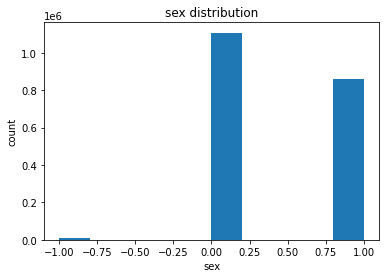

In [205]:
train_df['sex'].plot(kind='hist')
plt.title('sex distribution')
plt.xlabel('sex')
plt.ylabel('count')

In [206]:
pd.isnull(train_df['sex']).value_counts()

False    1978066
True         898
Name: sex, dtype: int64

In [207]:
#the number is small, we delete them directly

In [208]:
train_df.dropna(subset=['sex'],how='any',inplace=True)

In [209]:
pd.isnull(train_df['age']).value_counts()

False    1976863
True        1203
Name: age, dtype: int64

In [210]:
train_df.dropna(subset=['age'],how='any',inplace=True)

In [211]:
#drop the sex =-1 

In [212]:
train_df=train_df.drop(train_df[(train_df['sex']==-1)].index)

In [218]:
test_df=test_df.drop(test_df[(test_df['sex']==-1)].index)

In [219]:
pd.isnull(train_df['user_lv_cd']).value_counts()

False    1966395
Name: user_lv_cd, dtype: int64

In [220]:
pd.isnull(train_df['city_level']).value_counts()

False    1965527
True         868
Name: city_level, dtype: int64

In [221]:
train_df.dropna(subset=['city_level'],how='any',inplace=True)

In [222]:
train_df.describe()

cate       user_id        sku_id         brand       shop_id  \
count  1.965527e+06  1.965527e+06  1.965527e+06  1.965527e+06  1.965527e+06   
mean   4.023191e+01  8.038061e+05  1.903960e+05  5.082542e+03  5.169535e+03   
std    2.557973e+01  4.643604e+05  1.087215e+05  3.222473e+03  3.006952e+03   
min    1.000000e+00  1.000000e+00  1.300000e+01  1.000000e+00  1.000000e+00   
25%    2.000000e+01  4.017605e+05  9.748900e+04  2.484000e+03  2.491000e+03   
50%    3.400000e+01  8.035320e+05  1.889620e+05  4.491000e+03  5.166000e+03   
75%    6.900000e+01  1.206124e+06  2.856360e+05  7.954000e+03  7.831000e+03   
max    8.100000e+01  1.608707e+06  3.784560e+05  1.119900e+04  1.039900e+04   

            type           sex           age    user_lv_cd    city_level  
count  1965527.0  1.965527e+06  1.965527e+06  1.965527e+06  1.965527e+06  
mean         2.0  4.367104e-01  4.648215e+00  4.519657e+00  3.319064e+00  
std          0.0  4.959784e-01  1.465118e+00  2.383525e+00  1.415056e+00  
min          2.0  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
25%          2.0  0.000000e+00  4.000000e+00  1.000000e+00  3.000000e+00  
50%          2.0  0.000000e+00  5.000000e+00  5.000000e+00  4.000000e+00  
75%          2.0  1.000000e+00  6.000000e+00  6.000000e+00  4.000000e+00  
max          2.0  1.000000e+00  6.000000e+00  7.000000e+00  6.000000e+00

In [223]:
train_df.shape

(1965527, 11)

In [224]:
pd.isnull(train_df).values.any()

False

In [225]:
#Outliers

In [226]:
#statistic each product id sale in train set

Text(0, 0.5, 'sales')

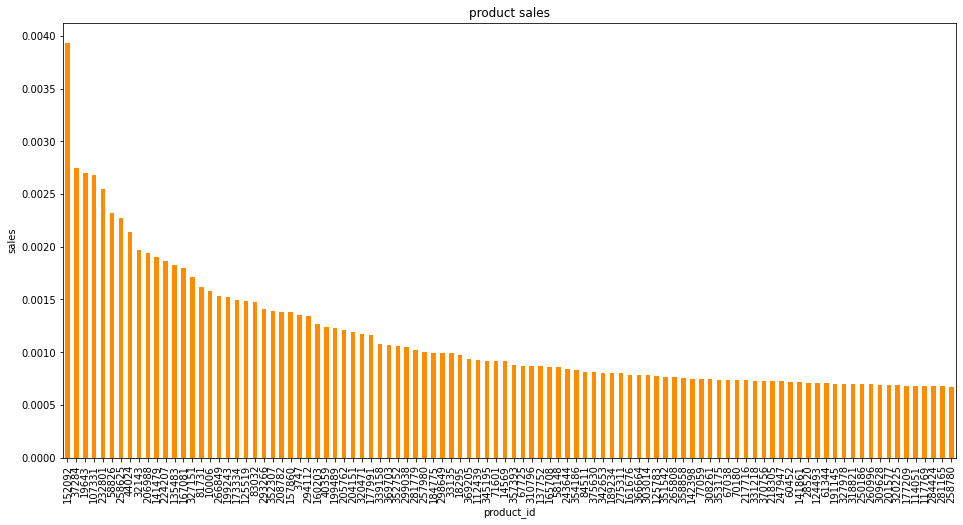

In [227]:
plt.figure(figsize=(16,8))
train_df['sku_id'].value_counts(normalize=True)[:100].plot(kind='bar',color='darkorange')
plt.title('product sales')
plt.xlabel('product_id')
plt.ylabel('sales')

In [228]:
train_df['sku_id'].value_counts(ascending=False)[:5]

152092    7721
37284     5408
19643     5308
107331    5273
232801    5001
Name: sku_id, dtype: int64

In [229]:
train_df[train_df['sku_id']==152092]

cate  user_id  sku_id            action_time  brand  shop_id  type  \
9610       69   161965  152092  2018-03-13 11:55:12.0   5277     4005     2   
9627       69     1092  152092  2018-03-29 17:08:11.0   5277     4005     2   
9659       69  1204522  152092  2018-02-06 09:09:21.0   5277     4005     2   
9661       69   333311  152092  2018-04-03 09:28:48.0   5277     4005     2   
9670       69   640484  152092  2018-02-11 07:39:09.0   5277     4005     2   
...       ...      ...     ...                    ...    ...      ...   ...   
1972808    69   257777  152092  2018-03-23 13:43:13.0   5277     4005     2   
1972846    69   508957  152092  2018-02-05 19:45:08.0   5277     4005     2   
1972878    69  1337253  152092  2018-03-26 23:43:00.0   5277     4005     2   
1972879    69  1022656  152092  2018-02-17 19:13:11.0   5277     4005     2   
1972885    69   462970  152092  2018-03-25 15:46:03.0   5277     4005     2   

         sex  age  user_lv_cd  city_level  
9610     1.0  5.0           5         5.0  
9627     0.0  6.0           6         4.0  
9659     0.0  5.0           5         4.0  
9661     0.0  5.0           1         4.0  
9670     0.0  6.0           6         4.0  
...      ...  ...         ...         ...  
1972808  1.0  6.0           6         1.0  
1972846  0.0  6.0           1         5.0  
1972878  0.0  2.0           1         5.0  
1972879  0.0  5.0           7         5.0  
1972885  0.0  5.0           1         4.0  

[7721 rows x 11 columns]

In [230]:
#change date form

In [231]:
train_df['action_time']=pd.to_datetime(train_df['action_time']).dt.strftime('%Y%m%d')
train_df['action_time']

1          20180302
2          20180206
3          20180308
4          20180205
5          20180218
             ...   
1978959    20180403
1978960    20180304
1978961    20180312
1978962    20180313
1978963    20180211
Name: action_time, Length: 1965527, dtype: object

In [232]:
train_df[train_df['sku_id']==152092].value_counts('action_time')

action_time
20180328    380
20180312    272
20180204    253
20180228    214
20180205    193
           ... 
20180218     37
20180217     35
20180214     31
20180216     22
20180215     20
Length: 68, dtype: int64

Text(0, 0.5, 'sales')

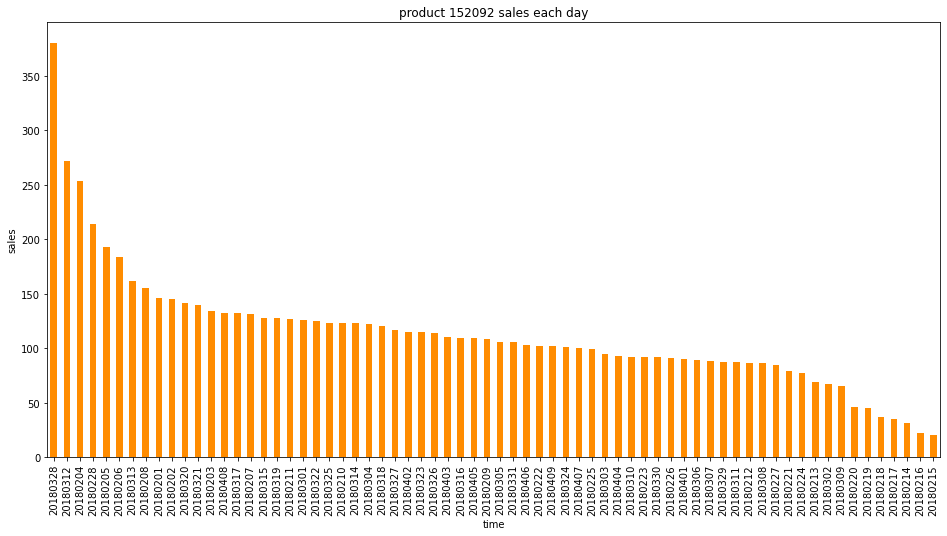

In [46]:
plt.figure(figsize=(16,8))
train_df[train_df['sku_id']==152092].value_counts('action_time').plot(kind='bar',color='darkorange')
plt.title('product 152092 sales each day')
plt.xlabel('time')
plt.ylabel('sales')

In [233]:
train_df['sku_id'].value_counts(ascending=True)[:10]

4094      1
109230    1
117410    1
10910     1
15004     1
357811    1
332345    1
365097    1
329149    1
287255    1
Name: sku_id, dtype: int64

In [234]:
#change action time to number representing

In [235]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_df['date_num'] = label_encoder.fit_transform(train_df['action_time'])

In [236]:
train_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
1          79  1008776   31647    20180302  10511     9665     2  0.0  6.0   
2          79  1569797  141162    20180206   4854       79     2  1.0  5.0   
3          79  1066676  102904    20180308   1226     7129     2  1.0  6.0   
4          79  1314628  102417    20180205   5700     1553     2  1.0  5.0   
5          79   982912  264665    20180218   1898     1182     2  0.0  5.0   
...       ...      ...     ...         ...    ...      ...   ...  ...  ...   
1978959     3   254643  126121    20180403   4854     5338     2  1.0  5.0   
1978960    24  1233285  373243    20180304   2540     4211     2  1.0  6.0   
1978961    10   138926   42714    20180312   8570     2738     2  0.0  5.0   
1978962    45   118627   54885    20180313   5309     7400     2  0.0  5.0   
1978963    31   767401  105868    20180211   8734     7918     2  0.0  5.0   

         user_lv_cd  city_level  date_num  
1                 7         4.0        29  
2                 5         4.0         5  
3                 7         1.0        35  
4                 5         1.0         4  
5                 5         1.0        17  
...             ...         ...       ...  
1978959           1         4.0        61  
1978960           7         4.0        31  
1978961           6         5.0        39  
1978962           1         4.0        40  
1978963           7         1.0        10  

[1965527 rows x 12 columns]

In [237]:
from itertools import product

In [238]:
#create certesian tuple cate-sku_id-day_time in train set

In [60]:
cate_sale_day0=train_df.loc[train_df['date_num']==0,'cate'].unique()
sku_sale_day0=train_df.loc[train_df['date_num']==0,'sku_id'].unique()
day0=list(product(*[cate_sale_day0,sku_sale_day0,[0]]))

In [61]:
day0[:5]

[(79, 307497, 0),
 (79, 315374, 0),
 (79, 299672, 0),
 (79, 246872, 0),
 (79, 56948, 0)]

In [62]:
len(day0)

1227072

In [63]:
days=train_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=train_df.loc[train_df['date_num']==day,'cate'].unique()
    sex_day=train_df.loc[train_df['date_num']==day,'sex'].unique()
    age_day=train_df.loc[train_df['date_num']==day,'age'].unique()
    user_level_day=train_df.loc[train_df['date_num']==day,'user_lv_cd'].unique()
    city_level_day=train_df.loc[train_df['date_num']==day,'city_level'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,user_level_day,city_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','user_lv_cd','city_level','date_num'],dtype=np.int32)

In [64]:
cartesian_df

cate  sex  age  user_lv_cd  city_level  date_num
0          79    0    6           7           4        29
1          79    0    6           7           5        29
2          79    0    6           7           3        29
3          79    0    6           7           1        29
4          79    0    6           7           2        29
...       ...  ...  ...         ...         ...       ...
2191135    54    1    3           3           3        65
2191136    54    1    3           3           5        65
2191137    54    1    3           3           2        65
2191138    54    1    3           3           1        65
2191139    54    1    3           3           6        65

[2191140 rows x 6 columns]

In [65]:
#calculate the total sale of each product each day

In [66]:
train_df.insert(train_df.shape[1],'count',1)

In [67]:
train_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
1          79  1008776   31647    20180302  10511     9665     2  0.0  6.0   
2          79  1569797  141162    20180206   4854       79     2  1.0  5.0   
3          79  1066676  102904    20180308   1226     7129     2  1.0  6.0   
4          79  1314628  102417    20180205   5700     1553     2  1.0  5.0   
5          79   982912  264665    20180218   1898     1182     2  0.0  5.0   
...       ...      ...     ...         ...    ...      ...   ...  ...  ...   
1978959     3   254643  126121    20180403   4854     5338     2  1.0  5.0   
1978960    24  1233285  373243    20180304   2540     4211     2  1.0  6.0   
1978961    10   138926   42714    20180312   8570     2738     2  0.0  5.0   
1978962    45   118627   54885    20180313   5309     7400     2  0.0  5.0   
1978963    31   767401  105868    20180211   8734     7918     2  0.0  5.0   

         user_lv_cd  city_level  date_num  count  
1                 7         4.0        29      1  
2                 5         4.0         5      1  
3                 7         1.0        35      1  
4                 5         1.0         4      1  
5                 5         1.0        17      1  
...             ...         ...       ...    ...  
1978959           1         4.0        61      1  
1978960           7         4.0        31      1  
1978961           6         5.0        39      1  
1978962           1         4.0        40      1  
1978963           7         1.0        10      1  

[1965527 rows x 13 columns]

In [68]:
x=train_df.groupby(['cate','sex','age','user_lv_cd','city_level','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
0          1  0.0  1.0           1         1.0        13      1
1          1  0.0  1.0           1         1.0        31      1
2          1  0.0  1.0           1         3.0        61      1
3          1  0.0  1.0           1         4.0        20      1
4          1  0.0  1.0           1         4.0        59      1
...      ...  ...  ...         ...         ...       ...    ...
403146    81  1.0  6.0           7         5.0        66      3
403147    81  1.0  6.0           7         5.0        67      6
403148    81  1.0  6.0           7         6.0        31      1
403149    81  1.0  6.0           7         6.0        36      1
403150    81  1.0  6.0           7         6.0        57      1

[403151 rows x 7 columns]

In [69]:
#merge cartesian list and sale column

In [70]:
train_new=pd.merge(cartesian_df,x,on=['cate','age','sex','user_lv_cd','city_level','date_num'],how='left').fillna(0)

In [71]:
train_new

cate  sex  age  user_lv_cd  city_level  date_num  sales
0          79    0    6           7           4        29    5.0
1          79    0    6           7           5        29    2.0
2          79    0    6           7           3        29    5.0
3          79    0    6           7           1        29    4.0
4          79    0    6           7           2        29    1.0
...       ...  ...  ...         ...         ...       ...    ...
2191135    54    1    3           3           3        65    0.0
2191136    54    1    3           3           5        65    0.0
2191137    54    1    3           3           2        65    0.0
2191138    54    1    3           3           1        65    0.0
2191139    54    1    3           3           6        65    0.0

[2191140 rows x 7 columns]

In [72]:
#sort the dataframe

In [73]:
train_new.sort_values(['date_num','cate','user_lv_cd','city_level'],inplace=True)
train_new

cate  sex  age  user_lv_cd  city_level  date_num  sales
190326      1    0    5           1           1         0    0.0
190368      1    0    1           1           1         0    0.0
190410      1    0    6           1           1         0    0.0
190452      1    0    4           1           1         0    0.0
190494      1    0    2           1           1         0    0.0
...       ...  ...  ...         ...         ...       ...    ...
2103755    81    0    2           7           6        67    1.0
2103797    81    0    5           7           6        67    0.0
2103839    81    0    4           7           6        67    0.0
2103881    81    0    1           7           6        67    0.0
2103923    81    0    3           7           6        67    0.0

[2191140 rows x 7 columns]

In [74]:
train_new.describe()

cate        sex           age    user_lv_cd    city_level  \
count  2.191140e+06  2191140.0  2.191140e+06  2.191140e+06  2.191140e+06   
mean   4.194665e+01        0.5  3.527265e+00  4.294575e+00  3.500000e+00   
std    2.322410e+01        0.5  1.749668e+00  1.978188e+00  1.707826e+00   
min    1.000000e+00        0.0  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.300000e+01        0.0  2.000000e+00  3.000000e+00  2.000000e+00   
50%    4.200000e+01        0.5  4.000000e+00  4.000000e+00  3.500000e+00   
75%    6.200000e+01        1.0  5.000000e+00  6.000000e+00  5.000000e+00   
max    8.100000e+01        1.0  6.000000e+00  7.000000e+00  6.000000e+00   

           date_num         sales  
count  2.191140e+06  2.191140e+06  
mean   3.413298e+01  8.970340e-01  
std    1.984834e+01  4.939491e+00  
min    0.000000e+00  0.000000e+00  
25%    1.700000e+01  0.000000e+00  
50%    3.400000e+01  0.000000e+00  
75%    5.100000e+01  0.000000e+00  
max    6.700000e+01  6.880000e+02

In [75]:
#data clean

In [76]:
train_new['sales'].max()

688.0

In [77]:
train_new[train_new['sales']==688]

cate  sex  age  user_lv_cd  city_level  date_num  sales
37814     7    0    5           7           3         5  688.0

In [78]:
x=train_new[train_new['cate']==7].sort_values(['sales'])
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
1185845     7    0    3           5           6        34    0.0
1565384     7    0    1           4           3        40    0.0
1565348     7    0    4           4           3        40    0.0
1565312     7    0    5           4           3        40    0.0
1565276     7    0    6           4           3        40    0.0
...       ...  ...  ...         ...         ...       ...    ...
37800       7    0    5           5           4         5  520.0
37812       7    0    5           7           4         5  580.0
37886       7    0    6           7           3         5  590.0
37884       7    0    6           7           4         5  596.0
37814       7    0    5           7           3         5  688.0

[28332 rows x 7 columns]

In [79]:
x=train_new.sort_values(['sales'])
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
190326     1    0    5           1           1         0    0.0
616588    11    0    1           6           5        44    0.0
616552    11    0    2           6           5        44    0.0
616516    11    0    6           6           5        44    0.0
616480    11    0    4           6           5        44    0.0
...      ...  ...  ...         ...         ...       ...    ...
37800      7    0    5           5           4         5  520.0
37812      7    0    5           7           4         5  580.0
37886      7    0    6           7           3         5  590.0
37884      7    0    6           7           4         5  596.0
37814      7    0    5           7           3         5  688.0

[2191140 rows x 7 columns]

In [80]:
x=train_new[train_new['cate']==1].sort_values(['sales'])
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
190326      1    0    5           1           1         0    0.0
347717      1    0    1           1           6        46    0.0
347681      1    0    4           1           6        46    0.0
347645      1    0    6           1           6        46    0.0
347609      1    0    5           1           6        46    0.0
...       ...  ...  ...         ...         ...       ...    ...
2079084     1    1    5           1           1        64    2.0
32881       1    0    5           1           5        29    3.0
1877403     1    0    5           6           1        57    3.0
1335334     1    1    6           7           1        26    3.0
953892      1    0    1           5           4        30    4.0

[28332 rows x 7 columns]

In [81]:
x=train_new[train_new['cate']==2].sort_values(['sales'])
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
1190165     2    0    3           5           6        34    0.0
595170      2    1    2           1           3        44    0.0
595134      2    1    6           1           3        44    0.0
595459      2    0    3           1           2        44    0.0
595423      2    0    1           1           2        44    0.0
...       ...  ...  ...         ...         ...       ...    ...
103902      2    0    5           1           1         4   15.0
769845      2    1    5           1           4        23   17.0
49464       2    0    5           5           4         5   18.0
1189983     2    0    5           5           5        34   20.0
932767      2    1    6           1           3        30   21.0

[28332 rows x 7 columns]

In [82]:
def find_outlier(cate_id):
    x=train_new[train_new['cate']==cate_id].sort_values(['sales'])
    print("cate_id is ",cate_id,x)

In [150]:
cate_num=train_df['cate'].unique()
for cate_id in cate_num:
    find_outlier(cate_id)

cate_id is  79          cate  sex  age  user_lv_cd  city_level  date_num  sales
160926     79    0    5           1           1         0    0.0
592173     79    1    1           5           4        44    0.0
592137     79    1    2           5           4        44    0.0
592065     79    1    4           5           4        44    0.0
592422     79    0    3           5           3        44    0.0
...       ...  ...  ...         ...         ...       ...    ...
625507     79    1    5           1           4        25   19.0
1145535    79    1    5           5           4        48   19.0
1498297    79    0    5           7           4        53   20.0
1044660    79    1    5           1           4        39   20.0
1077666    79    1    5           1           4        21   27.0

[28332 rows x 7 columns]
cate_id is  43          cate  sex  age  user_lv_cd  city_level  date_num  sales
1186277    43    0    3           5           6        34    0.0
1214148    43    0    3           

In [83]:
train_new=train_new.drop(train_new[(train_new['cate']==74)&(train_new['sales']==39)].index)
train_new=train_new.drop(train_new[(train_new['cate']==81)&(train_new['sales']==283)].index)
train_new=train_new.drop(train_new[(train_new['cate']==25)&(train_new['sales']==207)].index)
train_new=train_new.drop(train_new[(train_new['cate']==29)&(train_new['sales']==100)].index)

In [84]:
train_new.describe()

cate           sex           age    user_lv_cd    city_level  \
count  2.191135e+06  2.191135e+06  2.191135e+06  2.191135e+06  2.191135e+06   
mean   4.194663e+01  5.000007e-01  3.527261e+00  4.294571e+00  3.500001e+00   
std    2.322410e+01  5.000001e-01  1.749668e+00  1.978187e+00  1.707827e+00   
min    1.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.300000e+01  0.000000e+00  2.000000e+00  3.000000e+00  2.000000e+00   
50%    4.200000e+01  1.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
75%    6.200000e+01  1.000000e+00  5.000000e+00  6.000000e+00  5.000000e+00   
max    8.100000e+01  1.000000e+00  6.000000e+00  7.000000e+00  6.000000e+00   

           date_num         sales  
count  2.191135e+06  2.191135e+06  
mean   3.413297e+01  8.967033e-01  
std    1.984834e+01  4.932879e+00  
min    0.000000e+00  0.000000e+00  
25%    1.700000e+01  0.000000e+00  
50%    3.400000e+01  0.000000e+00  
75%    5.100000e+01  0.000000e+00  
max    6.700000e+01  6.880000e+02

In [85]:
train_new.shape

(2191135, 7)

<AxesSubplot:>

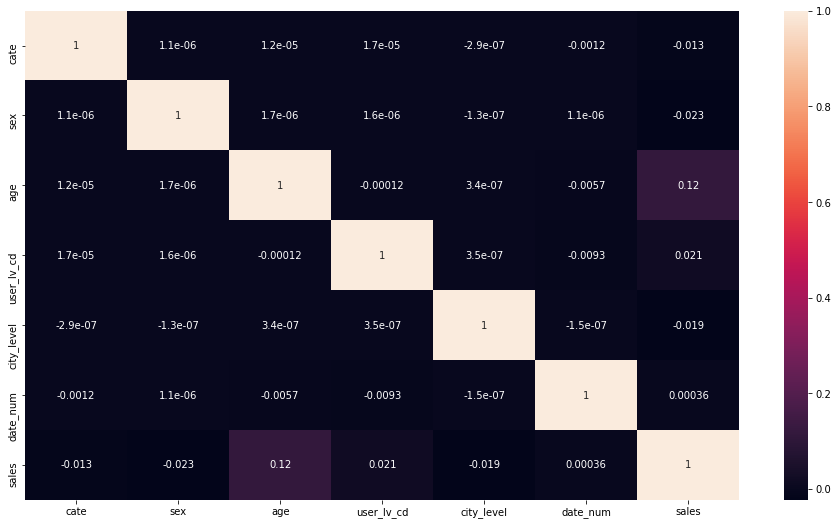

In [86]:
plt.subplots(figsize=(16,9))
correlation_mat=train_new.corr()
sns.heatmap(correlation_mat,annot=True)

In [87]:
#deal with test data

In [88]:
test_df.shape

(184682, 11)

In [89]:
test_df.dropna(how='any',inplace=True)

In [90]:
test_df.shape

(184456, 11)

In [91]:
test_df['action_time']=pd.to_datetime(test_df['action_time']).dt.strftime('%Y%m%d')
test_df['action_time']

2         20180410
3         20180412
4         20180410
5         20180411
6         20180410
            ...   
184677    20180410
184678    20180411
184679    20180415
184680    20180413
184681    20180413
Name: action_time, Length: 184456, dtype: object

In [92]:
label_encoder = preprocessing.LabelEncoder()
test_df['date_num'] = label_encoder.fit_transform(test_df['action_time'])
test_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
2         27  1074877  134144    20180410   6588     3663     2  0.0  5.0   
3         79   158811  114345    20180412   6574     4071     2  1.0  5.0   
4         72   852571  219951    20180410   3746     7196     2 -1.0  5.0   
5         79   817501  151783    20180411   9268     1259     2  0.0  6.0   
6         27  1306886  239072    20180410  10874     8771     2  1.0  6.0   
...      ...      ...     ...         ...    ...      ...   ...  ...  ...   
184677    43   681514   37925    20180410   2484     4019     2  0.0  5.0   
184678    34  1311043   86452    20180411   2484     9649     2  0.0  2.0   
184679    81   777706  281779    20180415    265     4222     2  1.0  5.0   
184680    41   720945  272638    20180413   3263     1315     2  1.0  6.0   
184681    20   341637  375223    20180413  11114      776     2  0.0  4.0   

        user_lv_cd  city_level  date_num  
2                7         1.0         0  
3                5         1.0         2  
4                6         1.0         0  
5                7         6.0         1  
6                1         4.0         0  
...            ...         ...       ...  
184677           5         5.0         0  
184678           7         4.0         1  
184679           5         4.0         5  
184680           1         1.0         3  
184681           6         5.0         3  

[184456 rows x 12 columns]

In [93]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sex_day=test_df.loc[test_df['date_num']==day,'sex'].unique()
    age_day=test_df.loc[test_df['date_num']==day,'age'].unique()
    user_level_day=test_df.loc[test_df['date_num']==day,'user_lv_cd'].unique()
    city_level_day=test_df.loc[test_df['date_num']==day,'city_level'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,user_level_day,city_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','user_lv_cd','city_level','date_num'],dtype=np.int32)

In [94]:
cartesian_df

cate  sex  age  user_lv_cd  city_level  date_num
0         27    0    5           7           1         0
1         27    0    5           7           4         0
2         27    0    5           7           5         0
3         27    0    5           7           3         0
4         27    0    5           7           2         0
...      ...  ...  ...         ...         ...       ...
285655    50   -1    1           3           4         3
285656    50   -1    1           3           5         3
285657    50   -1    1           3           3         3
285658    50   -1    1           3           2         3
285659    50   -1    1           3           6         3

[285660 rows x 6 columns]

In [95]:
test_df.insert(test_df.shape[1],'count',1)

In [96]:
test_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
2         27  1074877  134144    20180410   6588     3663     2  0.0  5.0   
3         79   158811  114345    20180412   6574     4071     2  1.0  5.0   
4         72   852571  219951    20180410   3746     7196     2 -1.0  5.0   
5         79   817501  151783    20180411   9268     1259     2  0.0  6.0   
6         27  1306886  239072    20180410  10874     8771     2  1.0  6.0   
...      ...      ...     ...         ...    ...      ...   ...  ...  ...   
184677    43   681514   37925    20180410   2484     4019     2  0.0  5.0   
184678    34  1311043   86452    20180411   2484     9649     2  0.0  2.0   
184679    81   777706  281779    20180415    265     4222     2  1.0  5.0   
184680    41   720945  272638    20180413   3263     1315     2  1.0  6.0   
184681    20   341637  375223    20180413  11114      776     2  0.0  4.0   

        user_lv_cd  city_level  date_num  count  
2                7         1.0         0      1  
3                5         1.0         2      1  
4                6         1.0         0      1  
5                7         6.0         1      1  
6                1         4.0         0      1  
...            ...         ...       ...    ...  
184677           5         5.0         0      1  
184678           7         4.0         1      1  
184679           5         4.0         5      1  
184680           1         1.0         3      1  
184681           6         5.0         3      1  

[184456 rows x 13 columns]

In [97]:
x=test_df.groupby(['cate','sex','age','user_lv_cd','city_level','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  user_lv_cd  city_level  date_num  sales
0         1  0.0  1.0           4         1.0         5      1
1         1  0.0  1.0           5         4.0         2      1
2         1  0.0  2.0           5         1.0         1      1
3         1  0.0  2.0           5         5.0         0      1
4         1  0.0  2.0           7         4.0         0      1
...     ...  ...  ...         ...         ...       ...    ...
41274    81  1.0  6.0           7         5.0         0      3
41275    81  1.0  6.0           7         5.0         1      3
41276    81  1.0  6.0           7         5.0         2      4
41277    81  1.0  6.0           7         5.0         3      4
41278    81  1.0  6.0           7         5.0         4      3

[41279 rows x 7 columns]

In [98]:
test_new=x
test_new

cate  sex  age  user_lv_cd  city_level  date_num  sales
0         1  0.0  1.0           4         1.0         5      1
1         1  0.0  1.0           5         4.0         2      1
2         1  0.0  2.0           5         1.0         1      1
3         1  0.0  2.0           5         5.0         0      1
4         1  0.0  2.0           7         4.0         0      1
...     ...  ...  ...         ...         ...       ...    ...
41274    81  1.0  6.0           7         5.0         0      3
41275    81  1.0  6.0           7         5.0         1      3
41276    81  1.0  6.0           7         5.0         2      4
41277    81  1.0  6.0           7         5.0         3      4
41278    81  1.0  6.0           7         5.0         4      3

[41279 rows x 7 columns]

In [99]:
test_new.sort_values(['date_num','cate','city_level','user_lv_cd'],inplace=True)
test_new

cate  sex  age  user_lv_cd  city_level  date_num  sales
5         1  0.0  5.0           1         1.0         0      1
9         1  0.0  5.0           6         1.0         0      1
34        1  1.0  5.0           6         1.0         0      1
35        1  1.0  5.0           7         1.0         0      1
16        1  0.0  6.0           7         3.0         0      1
...     ...  ...  ...         ...         ...       ...    ...
40815    81  0.0  6.0           7         5.0         5     34
40990    81  1.0  2.0           7         5.0         5      1
41066    81  1.0  4.0           7         5.0         5      1
41176    81  1.0  5.0           7         5.0         5      5
40648    81  0.0  5.0           6         6.0         5      1

[41279 rows x 7 columns]

In [100]:
#cross validation

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
from xgboost import XGBRegressor

In [88]:
from sklearn.metrics import r2_score

In [89]:
model = XGBRegressor(n_estimators=3000,
                     max_depth=6,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.01
                    )

In [288]:
test_feature = test_new.drop(['sales'], axis=1)
test_value=test_new['sales'].values.tolist()
test_value

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 5,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 4,
 7,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 5,
 6,
 1,
 2,
 4,
 3,
 1,
 1,
 3,
 3,
 2,
 3,
 2,
 4,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 7,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 4,
 2,
 19,
 2,
 1,
 13,
 1,
 8,
 6,
 1,
 1,
 9,
 7,
 1,
 7,
 3,
 4,
 6,
 2,
 2,
 2,
 2,
 1,
 15,
 5,
 1,
 7,
 3,
 11,
 5,
 1,
 3,
 1,
 13,
 10,
 2,
 14,
 12,
 11,
 1,
 19,
 8,
 6,
 1,
 1,
 14,
 8,
 5,
 1,
 2,
 12,
 1,
 15,
 9,
 16,
 3,
 1,
 6,
 5,
 1,
 16,
 6,
 1,
 1,
 3,
 7,
 10,
 1,
 3,
 4,
 1,
 1,
 4,
 3,
 5,
 2,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 12,
 17,
 5,
 31,
 31,
 1,
 1,
 16,
 7,
 10,
 5,
 6,
 13,
 3,
 5,
 40,
 48,
 1,
 1,
 11,
 4,
 1,
 1,
 8,
 10,
 13,
 29,
 26,
 5

In [83]:
def cv_xgb():
    model.fit(x_train.values, y_train.values, 
              eval_metric="rmse", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [294]:
for i in range (1,6):
    x_train,x_test,y_train,y_test=train_test_split(train_new.drop(['sales'], axis=1),train_new['sales'],test_size=0.2)
    cv_xgb()
    y_pred=y_pred = model.predict(test_feature.values)
    print(y_pred)
    pred_value=list(y_pred)
    print(r2_score(test_value,pred_value))

[0]	validation_0-rmse:4.94291	validation_1-rmse:4.96739
[1]	validation_0-rmse:4.93978	validation_1-rmse:4.96450
[2]	validation_0-rmse:4.93964	validation_1-rmse:4.96294
[3]	validation_0-rmse:4.93715	validation_1-rmse:4.96169
[4]	validation_0-rmse:4.93025	validation_1-rmse:4.95524
[5]	validation_0-rmse:4.92537	validation_1-rmse:4.95054
[6]	validation_0-rmse:4.92008	validation_1-rmse:4.94481
[7]	validation_0-rmse:4.91716	validation_1-rmse:4.94156
[8]	validation_0-rmse:4.91085	validation_1-rmse:4.93586
[9]	validation_0-rmse:4.90769	validation_1-rmse:4.93280
[10]	validation_0-rmse:4.90481	validation_1-rmse:4.93028
[11]	validation_0-rmse:4.90203	validation_1-rmse:4.92777
[12]	validation_0-rmse:4.89879	validation_1-rmse:4.92486
[13]	validation_0-rmse:4.89204	validation_1-rmse:4.91839
[14]	validation_0-rmse:4.88882	validation_1-rmse:4.91506
[15]	validation_0-rmse:4.88818	validation_1-rmse:4.91381
[16]	validation_0-rmse:4.88167	validation_1-rmse:4.90732
[17]	validation_0-rmse:4.87325	validation

In [ ]:
#[ 4.2644153   1.8239648   1.7443419  ... -0.20265895 10.878737 3.293589  ]
r_square:-0.8081965934408375
#[ 4.670927    2.008973    1.5832175  ...  0.06252995 11.039287 3.390657  ]
r_square:-0.7959125769093212
#[ 4.6794844   2.160028    1.884943   ... -0.49680534 10.494968 3.4939413 ]
r_square:-0.8236581344757286
#[ 4.315312   2.0294847  1.6229061 ... -0.3817626 10.991177   3.604299 ]
r_square:-0.9669368708845527
#[ 4.9898834  2.0297303  1.7447494 ... -0.6030519 10.415297   3.217343 ]
r_square:-0.8690159529868136

In [ ]:
#average R-square

In [296]:
np.mean([-0.8081965934408375,-0.7959125769093212,-0.8236581344757286,-0.9669368708845527,-0.8690159529868136])

-0.8527440257394506

In [ ]:
#the r-square is very bad,we choose other variable conbinations.

In [106]:
train_new2=train_new.drop(['date_num'],axis=1)

In [107]:
train_new2

cate  sex  age  user_lv_cd  city_level  sales
190326      1    0    5           1           1    0.0
190368      1    0    1           1           1    0.0
190410      1    0    6           1           1    0.0
190452      1    0    4           1           1    0.0
190494      1    0    2           1           1    0.0
...       ...  ...  ...         ...         ...    ...
2103755    81    0    2           7           6    1.0
2103797    81    0    5           7           6    0.0
2103839    81    0    4           7           6    0.0
2103881    81    0    1           7           6    0.0
2103923    81    0    3           7           6    0.0

[2191135 rows x 6 columns]

In [108]:
test_new2=test_new.drop(['date_num'],axis=1)

In [109]:
test_new2

cate  sex  age  user_lv_cd  city_level  sales
5         1  0.0  5.0           1         1.0      1
9         1  0.0  5.0           6         1.0      1
34        1  1.0  5.0           6         1.0      1
35        1  1.0  5.0           7         1.0      1
16        1  0.0  6.0           7         3.0      1
...     ...  ...  ...         ...         ...    ...
40815    81  0.0  6.0           7         5.0     34
40990    81  1.0  2.0           7         5.0      1
41066    81  1.0  4.0           7         5.0      1
41176    81  1.0  5.0           7         5.0      5
40648    81  0.0  5.0           6         6.0      1

[41279 rows x 6 columns]

In [110]:
test_feature2 = test_new2.drop(['sales'], axis=1)
test_value2=test_new2['sales'].values.tolist()
test_value2

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 5,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 3,
 2,
 2,
 4,
 7,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 1,
 1,
 5,
 6,
 1,
 2,
 4,
 3,
 1,
 1,
 3,
 3,
 2,
 3,
 2,
 4,
 1,
 2,
 1,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 4,
 1,
 1,
 2,
 2,
 1,
 1,
 3,
 1,
 1,
 2,
 2,
 7,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 4,
 2,
 19,
 2,
 1,
 13,
 1,
 8,
 6,
 1,
 1,
 9,
 7,
 1,
 7,
 3,
 4,
 6,
 2,
 2,
 2,
 2,
 1,
 15,
 5,
 1,
 7,
 3,
 11,
 5,
 1,
 3,
 1,
 13,
 10,
 2,
 14,
 12,
 11,
 1,
 19,
 8,
 6,
 1,
 1,
 14,
 8,
 5,
 1,
 2,
 12,
 1,
 15,
 9,
 16,
 3,
 1,
 6,
 5,
 1,
 16,
 6,
 1,
 1,
 3,
 7,
 10,
 1,
 3,
 4,
 1,
 1,
 4,
 3,
 5,
 2,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 12,
 17,
 5,
 31,
 31,
 1,
 1,
 16,
 7,
 10,
 5,
 6,
 13,
 3,
 5,
 40,
 48,
 1,
 1,
 11,
 4,
 1,
 1,
 8,
 10,
 13,
 29,
 26,
 5

In [82]:
def cv_xgb2():
    model.fit(x_train.values, y_train.values, 
              eval_metric="rmse", 
              eval_set=[(x_train.values, y_train.values), (x_test.values, y_test.values)], 
              verbose=True, 
              early_stopping_rounds = 50)

In [298]:
for i in range (1,6):
    x_train,x_test,y_train,y_test=train_test_split(train_new2.drop(['sales'], axis=1),train_new2['sales'],test_size=0.2)
    cv_xgb2()
    y_pred=model.predict(test_feature2.values)
    print(y_pred)
    pred_value=list(y_pred)
    print(r2_score(test_value2,pred_value))

[0]	validation_0-rmse:4.99913	validation_1-rmse:4.70681
[1]	validation_0-rmse:4.99531	validation_1-rmse:4.70425
[2]	validation_0-rmse:4.99643	validation_1-rmse:4.70300
[3]	validation_0-rmse:4.99585	validation_1-rmse:4.70125
[4]	validation_0-rmse:4.99027	validation_1-rmse:4.69535
[5]	validation_0-rmse:4.98698	validation_1-rmse:4.69236
[6]	validation_0-rmse:4.98560	validation_1-rmse:4.69118
[7]	validation_0-rmse:4.98430	validation_1-rmse:4.68972
[8]	validation_0-rmse:4.97950	validation_1-rmse:4.68488
[9]	validation_0-rmse:4.97819	validation_1-rmse:4.68342
[10]	validation_0-rmse:4.97499	validation_1-rmse:4.68037
[11]	validation_0-rmse:4.97337	validation_1-rmse:4.67899
[12]	validation_0-rmse:4.97033	validation_1-rmse:4.67634
[13]	validation_0-rmse:4.96476	validation_1-rmse:4.67069
[14]	validation_0-rmse:4.96166	validation_1-rmse:4.66783
[15]	validation_0-rmse:4.96089	validation_1-rmse:4.66680
[16]	validation_0-rmse:4.95716	validation_1-rmse:4.66265
[17]	validation_0-rmse:4.95120	validation

In [285]:
#[2.8020034 1.3093922 1.3813033 ... 2.3100517 9.328492  3.889116 ]
0.40830197709173555
#[2.8919861 1.3825595 1.5141866 ... 2.3406515 9.200722  3.9154122]
0.41349814188000533
#[2.8272717 1.3389277 1.4552312 ... 2.5361152 9.500432  3.8622777]
0.4103901991603214
#[2.8185334 1.3466095 1.4217329 ... 2.336631  9.4013405 3.8818023]
0.4111793411354382
#[2.8075929 1.3927689 1.4807013 ... 2.294352  9.124105  3.6861267]
0.411662673988647

In [299]:
np.mean([0.40830197709173555,0.41349814188000533,0.4103901991603214,0.4111793411354382,0.411662673988647])

0.4110064666512295

In [301]:
test_new2['Pred'] = y_pred
test_new2.to_csv('/Users/charles/Desktop/consumer/Prediction_next_week_with_realvalue.csv', index=False)

In [ ]:
#adjust parameters

In [115]:
model = XGBRegressor(n_estimators=500,
                     max_depth=4,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.2,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )

In [116]:
x_train,x_test,y_train,y_test=train_test_split(train_new2.drop(['sales'], axis=1),train_new2['sales'],test_size=0.2)
cv_xgb2()
y_pred=model.predict(test_feature2.values)
print(y_pred)
pred_value=list(y_pred)
print(r2_score(test_value2,pred_value))

[0]	validation_0-rmse:4.86331	validation_1-rmse:4.92729
[1]	validation_0-rmse:4.82917	validation_1-rmse:4.89553
[2]	validation_0-rmse:4.81955	validation_1-rmse:4.88441
[3]	validation_0-rmse:4.79532	validation_1-rmse:4.85936
[4]	validation_0-rmse:4.72864	validation_1-rmse:4.79143
[5]	validation_0-rmse:4.69884	validation_1-rmse:4.76170
[6]	validation_0-rmse:4.68829	validation_1-rmse:4.75170
[7]	validation_0-rmse:4.68112	validation_1-rmse:4.74461
[8]	validation_0-rmse:4.66220	validation_1-rmse:4.72566
[9]	validation_0-rmse:4.65766	validation_1-rmse:4.72117
[10]	validation_0-rmse:4.64294	validation_1-rmse:4.70656
[11]	validation_0-rmse:4.64084	validation_1-rmse:4.70438
[12]	validation_0-rmse:4.62454	validation_1-rmse:4.68832
[13]	validation_0-rmse:4.60914	validation_1-rmse:4.67310
[14]	validation_0-rmse:4.60010	validation_1-rmse:4.66427
[15]	validation_0-rmse:4.59653	validation_1-rmse:4.66076
[16]	validation_0-rmse:4.54975	validation_1-rmse:4.61229
[17]	validation_0-rmse:4.51719	validation

In [117]:
#we find it is meaningless even though adjust parameters

In [118]:
#we decide re-produce the dataset(add sku_id value)

In [53]:
days=train_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=train_df.loc[train_df['date_num']==day,'cate'].unique()
    sku_sale_day=train_df.loc[train_df['date_num']==day,'sku_id'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sku_sale_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sku_id','date_num'],dtype=np.int32)

In [54]:
cartesian_df

cate  sku_id  date_num
0           79   31647        29
1           79  370012        29
2           79  167639        29
3           79   66128        29
4           79  221695        29
...        ...     ...       ...
62588741    54  253703        65
62588742    54   23596        65
62588743    54  308873        65
62588744    54  129038        65
62588745    54  192762        65

[62588746 rows x 3 columns]

In [55]:
#calculate the total sale of each product each day

In [241]:
train_df.insert(train_df.shape[1],'count',1)

In [242]:
train_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
1          79  1008776   31647    20180302  10511     9665     2  0.0  6.0   
2          79  1569797  141162    20180206   4854       79     2  1.0  5.0   
3          79  1066676  102904    20180308   1226     7129     2  1.0  6.0   
4          79  1314628  102417    20180205   5700     1553     2  1.0  5.0   
5          79   982912  264665    20180218   1898     1182     2  0.0  5.0   
...       ...      ...     ...         ...    ...      ...   ...  ...  ...   
1978959     3   254643  126121    20180403   4854     5338     2  1.0  5.0   
1978960    24  1233285  373243    20180304   2540     4211     2  1.0  6.0   
1978961    10   138926   42714    20180312   8570     2738     2  0.0  5.0   
1978962    45   118627   54885    20180313   5309     7400     2  0.0  5.0   
1978963    31   767401  105868    20180211   8734     7918     2  0.0  5.0   

         user_lv_cd  city_level  date_num  count  
1                 7         4.0        29      1  
2                 5         4.0         5      1  
3                 7         1.0        35      1  
4                 5         1.0         4      1  
5                 5         1.0        17      1  
...             ...         ...       ...    ...  
1978959           1         4.0        61      1  
1978960           7         4.0        31      1  
1978961           6         5.0        39      1  
1978962           1         4.0        40      1  
1978963           7         1.0        10      1  

[1965527 rows x 13 columns]

In [58]:
x=train_df.groupby(['cate','sku_id','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sku_id  date_num  sales
0          1    2304         6      1
1          1    3539        21      1
2          1    3539        39      1
3          1    3539        42      1
4          1    3539        54      1
...      ...     ...       ...    ...
807251    81  378373        49      1
807252    81  378373        55      7
807253    81  378373        59      1
807254    81  378395        65      1
807255    81  378435        45      1

[807256 rows x 4 columns]

In [59]:
#merge cartesian list and sale column

In [60]:
train_new=pd.merge(cartesian_df,x,on=['cate','sku_id','date_num'],how='left').fillna(0)

In [61]:
train_new

cate  sku_id  date_num  sales
0           79   31647        29    4.0
1           79  370012        29    1.0
2           79  167639        29    9.0
3           79   66128        29    3.0
4           79  221695        29   12.0
...        ...     ...       ...    ...
62588741    54  253703        65    0.0
62588742    54   23596        65    0.0
62588743    54  308873        65    0.0
62588744    54  129038        65    0.0
62588745    54  192762        65    0.0

[62588746 rows x 4 columns]

In [62]:
#sort the dataframe

In [63]:
train_new.sort_values(['date_num','cate'],inplace=True)
train_new

cate  sku_id  date_num  sales
5928843      1  307497         0    0.0
5928844      1  315374         0    0.0
5928845      1  299672         0    0.0
5928846      1  246872         0    0.0
5928847      1   56948         0    0.0
...        ...     ...       ...    ...
60166862    81    5574        67    0.0
60166863    81  277882        67    0.0
60166864    81  123507        67    0.0
60166865    81  303626        67    0.0
60166866    81   80200        67    0.0

[62588746 rows x 4 columns]

In [64]:
#data clean

In [65]:
x=train_new.sort_values(['sales'])
x

cate  sku_id  date_num   sales
5928843      1  307497         0     0.0
10571524    29  288077        46     0.0
10571525    29   86022        46     0.0
10571526    29  183407        46     0.0
10571527    29  250538        46     0.0
...        ...     ...       ...     ...
16448571    67  272313        52   723.0
33370710    23  312817        49   812.0
4893095      7  288370         0   866.0
16287524    81  147902        52  1165.0
1133481      7  258625         5  1253.0

[62588746 rows x 4 columns]

In [66]:
train_new=train_new.drop(train_new[(train_new['cate']==7)&(train_new['sales']==1253)].index)
train_new=train_new.drop(train_new[(train_new['cate']==81)&(train_new['sales']==1165)].index)
train_new=train_new.drop(train_new[(train_new['cate']==7)&(train_new['sales']==866)].index)
train_new=train_new.drop(train_new[(train_new['cate']==67)&(train_new['sales']==723)].index)
train_new=train_new.drop(train_new[(train_new['cate']==23)&(train_new['sales']==812)].index)

In [67]:
train_new.shape

(62588741, 4)

<AxesSubplot:>

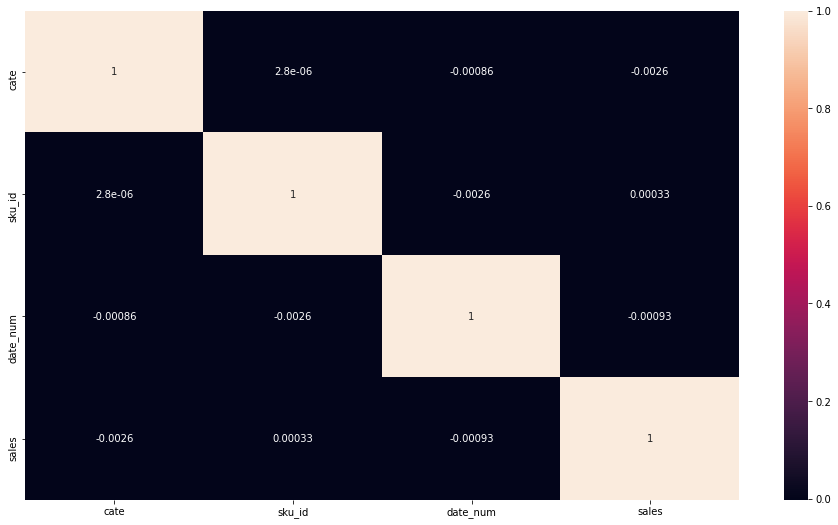

In [68]:
plt.subplots(figsize=(16,9))
correlation_mat=train_new.corr()
sns.heatmap(correlation_mat,annot=True)

In [69]:
test_df.shape

(184682, 11)

In [256]:
test_df.dropna(how='any',inplace=True)
test_df.shape

(183410, 12)

In [257]:
test_df['action_time']=pd.to_datetime(test_df['action_time']).dt.strftime('%Y%m%d')
test_df['action_time']

2         20180410
3         20180412
5         20180411
6         20180410
7         20180415
            ...   
184677    20180410
184678    20180411
184679    20180415
184680    20180413
184681    20180413
Name: action_time, Length: 183410, dtype: object

In [258]:
label_encoder = preprocessing.LabelEncoder()
test_df['date_num'] = label_encoder.fit_transform(test_df['action_time'])
test_df

cate  user_id  sku_id action_time  brand  shop_id  type  sex  age  \
2         27  1074877  134144    20180410   6588     3663     2  0.0  5.0   
3         79   158811  114345    20180412   6574     4071     2  1.0  5.0   
5         79   817501  151783    20180411   9268     1259     2  0.0  6.0   
6         27  1306886  239072    20180410  10874     8771     2  1.0  6.0   
7         79   391982  148169    20180415   4361     8120     2  0.0  6.0   
...      ...      ...     ...         ...    ...      ...   ...  ...  ...   
184677    43   681514   37925    20180410   2484     4019     2  0.0  5.0   
184678    34  1311043   86452    20180411   2484     9649     2  0.0  2.0   
184679    81   777706  281779    20180415    265     4222     2  1.0  5.0   
184680    41   720945  272638    20180413   3263     1315     2  1.0  6.0   
184681    20   341637  375223    20180413  11114      776     2  0.0  4.0   

        user_lv_cd  city_level  count  date_num  
2                7         1.0      1         0  
3                5         1.0      1         2  
5                7         6.0      1         1  
6                1         4.0      1         0  
7                7         1.0      1         5  
...            ...         ...    ...       ...  
184677           5         5.0      1         0  
184678           7         4.0      1         1  
184679           5         4.0      1         5  
184680           1         1.0      1         3  
184681           6         5.0      1         3  

[183410 rows x 13 columns]

In [73]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sku_sale_day=test_df.loc[test_df['date_num']==day,'sku_id'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sku_sale_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sku_id','date_num'],dtype=np.int32)
cartesian_df

cate  sku_id  date_num
0          27  134144         0
1          27  219951         0
2          27  239072         0
3          27  101918         0
4          27    9275         0
...       ...     ...       ...
6029742    50   90779         3
6029743    50   40268         3
6029744    50  143840         3
6029745    50  265852         3
6029746    50   25310         3

[6029747 rows x 3 columns]

In [252]:
test_df.insert(test_df.shape[1],'count',1)

In [253]:
test_df

cate  user_id  sku_id            action_time  brand  shop_id  type  \
0         79   537520   58984  2018-04-14 18:44:53.0   2564     1095     2   
1         19  1195693  261922  2018-04-14 17:48:01.0   7357     4059     2   
2         27  1074877  134144  2018-04-10 16:15:11.0   6588     3663     2   
3         79   158811  114345  2018-04-12 13:19:58.0   6574     4071     2   
5         79   817501  151783  2018-04-11 21:51:56.0   9268     1259     2   
...      ...      ...     ...                    ...    ...      ...   ...   
184677    43   681514   37925  2018-04-10 19:18:38.0   2484     4019     2   
184678    34  1311043   86452  2018-04-11 19:14:56.0   2484     9649     2   
184679    81   777706  281779  2018-04-15 13:52:59.0    265     4222     2   
184680    41   720945  272638  2018-04-13 20:40:28.0   3263     1315     2   
184681    20   341637  375223  2018-04-13 16:58:35.0  11114      776     2   

        sex  age  user_lv_cd  city_level  count  
0       NaN  NaN           5         NaN      1  
1       1.0  5.0           1         NaN      1  
2       0.0  5.0           7         1.0      1  
3       1.0  5.0           5         1.0      1  
5       0.0  6.0           7         6.0      1  
...     ...  ...         ...         ...    ...  
184677  0.0  5.0           5         5.0      1  
184678  0.0  2.0           7         4.0      1  
184679  1.0  5.0           5         4.0      1  
184680  1.0  6.0           1         1.0      1  
184681  0.0  4.0           6         5.0      1  

[183590 rows x 12 columns]

In [76]:
x=test_df.groupby(['cate','sku_id','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sku_id  date_num  sales
0         1   14895         2      1
1         1   18461         0      1
2         1   25504         5      1
3         1   41819         0      1
4         1   41819         3      1
...     ...     ...       ...    ...
77473    81  376196         3      1
77474    81  376348         4      1
77475    81  376730         1      1
77476    81  376979         5      1
77477    81  377280         5      1

[77478 rows x 4 columns]

In [77]:
test_new=x
test_new

cate  sku_id  date_num  sales
0         1   14895         2      1
1         1   18461         0      1
2         1   25504         5      1
3         1   41819         0      1
4         1   41819         3      1
...     ...     ...       ...    ...
77473    81  376196         3      1
77474    81  376348         4      1
77475    81  376730         1      1
77476    81  376979         5      1
77477    81  377280         5      1

[77478 rows x 4 columns]

In [115]:
model = XGBRegressor(n_estimators=1000,
                     max_depth=5,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.1
                    )

In [81]:
test_feature = test_new.drop(['sales'], axis=1)
test_value=test_new['sales'].values.tolist()
test_value

[1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 5,
 5,
 7,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 5,
 4,
 3,
 1,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 2,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 2,
 2,
 3,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 3,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 4,
 1,
 1,
 2,
 2,
 1,
 26,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 9,
 8,
 5,
 8,
 10,
 7,
 1,
 1,
 1,
 2,
 2,
 4,
 3,
 6,
 6,
 6,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 9,
 1,
 6,
 6,
 5,
 7,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 5,
 4,
 2,
 3,
 5,
 3,
 2,
 1,
 1,
 1

In [92]:
x_train,x_test,y_train,y_test=train_test_split(train_new.drop(['sales'], axis=1),train_new['sales'],test_size=0.2)
cv_xgb()
y_pred=model.predict(test_feature.values)
print(y_pred)
pred_value=list(y_pred)
print(r2_score(test_value,pred_value))

[0]	validation_0-rmse:0.93284	validation_1-rmse:1.02730
[1]	validation_0-rmse:0.92404	validation_1-rmse:0.99652
[2]	validation_0-rmse:0.92144	validation_1-rmse:0.98505
[3]	validation_0-rmse:0.88913	validation_1-rmse:0.97905
[4]	validation_0-rmse:0.88544	validation_1-rmse:0.97164
[5]	validation_0-rmse:0.88433	validation_1-rmse:0.96675
[6]	validation_0-rmse:0.88278	validation_1-rmse:0.96149
[7]	validation_0-rmse:0.87498	validation_1-rmse:0.93987
[8]	validation_0-rmse:0.87440	validation_1-rmse:0.93717
[9]	validation_0-rmse:0.87424	validation_1-rmse:0.93565
[10]	validation_0-rmse:0.87264	validation_1-rmse:0.93048
[11]	validation_0-rmse:0.87211	validation_1-rmse:0.92841
[12]	validation_0-rmse:0.87205	validation_1-rmse:0.92743
[13]	validation_0-rmse:0.87251	validation_1-rmse:0.92737
[14]	validation_0-rmse:0.87236	validation_1-rmse:0.92577
[15]	validation_0-rmse:0.87247	validation_1-rmse:0.92539
[16]	validation_0-rmse:0.87261	validation_1-rmse:0.92516
[17]	validation_0-rmse:0.87281	validation

In [239]:
days=train_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=train_df.loc[train_df['date_num']==day,'cate'].unique()
    sex_day=train_df.loc[train_df['date_num']==day,'sex'].unique()
    age_day=train_df.loc[train_df['date_num']==day,'age'].unique()
    user_level_day=train_df.loc[train_df['date_num']==day,'user_lv_cd'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,user_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','user_lv_cd','date_num'],dtype=np.int32)
cartesian_df

cate  sex  age  user_lv_cd  date_num
0         79    0    6           7        29
1         79    0    6           5        29
2         79    0    6           1        29
3         79    0    6           6        29
4         79    0    6           4        29
...      ...  ...  ...         ...       ...
365185    54    1    3           7        65
365186    54    1    3           6        65
365187    54    1    3           5        65
365188    54    1    3           4        65
365189    54    1    3           3        65

[365190 rows x 5 columns]

In [243]:
x=train_df.groupby(['cate','sex','age','user_lv_cd','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  user_lv_cd  date_num  sales
0          1  0.0  1.0           1        13      1
1          1  0.0  1.0           1        20      2
2          1  0.0  1.0           1        23      1
3          1  0.0  1.0           1        31      1
4          1  0.0  1.0           1        47      1
...      ...  ...  ...         ...       ...    ...
150529    81  1.0  6.0           7        63     19
150530    81  1.0  6.0           7        64     60
150531    81  1.0  6.0           7        65     31
150532    81  1.0  6.0           7        66     31
150533    81  1.0  6.0           7        67     47

[150534 rows x 6 columns]

In [244]:
train_new=pd.merge(cartesian_df,x,on=['cate','age','sex','user_lv_cd','date_num'],how='left').fillna(0)
train_new

cate  sex  age  user_lv_cd  date_num  sales
0         79    0    6           7        29   17.0
1         79    0    6           5        29    3.0
2         79    0    6           1        29    1.0
3         79    0    6           6        29    4.0
4         79    0    6           4        29    0.0
...      ...  ...  ...         ...       ...    ...
365185    54    1    3           7        65    0.0
365186    54    1    3           6        65    0.0
365187    54    1    3           5        65    0.0
365188    54    1    3           4        65    0.0
365189    54    1    3           3        65    0.0

[365190 rows x 6 columns]

In [245]:
x=train_new.sort_values(['sales'])
x

cate  sex  age  user_lv_cd  date_num   sales
182594    60    1    3           7        21     0.0
214019    31    0    5           4        12     0.0
214024    31    0    6           3        12     0.0
214025    31    0    6           4        12     0.0
214027    31    0    4           7        12     0.0
...      ...  ...  ...         ...       ...     ...
132476     7    0    5           7         2  1491.0
27172      7    0    5           7         0  1543.0
6300       7    0    5           5         5  1745.0
6314       7    0    6           7         5  1851.0
6302       7    0    5           7         5  2012.0

[365190 rows x 6 columns]

In [246]:
x=train_new[train_new['cate']==7].sort_values(['sales'])
x

cate  sex  age  user_lv_cd  date_num   sales
359789     7    1    3           3        65     0.0
175511     7    0    6           4        39     0.0
175522     7    0    4           3        39     0.0
175523     7    0    4           4        39     0.0
175529     7    0    1           4        39     0.0
...      ...  ...  ...         ...       ...     ...
132476     7    0    5           7         2  1491.0
27172      7    0    5           7         0  1543.0
6300       7    0    5           5         5  1745.0
6314       7    0    6           7         5  1851.0
6302       7    0    5           7         5  2012.0

[4722 rows x 6 columns]

In [99]:
train_new[train_new['cate']==7].describe()

cate          sex          age   user_lv_cd     date_num        sales
count  4722.0  4722.000000  4722.000000  4722.000000  4722.000000  4722.000000
mean      7.0     0.500000     3.527319     4.294790    34.033460    54.615205
std       0.0     0.500053     1.749934     1.978365    19.884611   148.725842
min       7.0     0.000000     1.000000     1.000000     0.000000     0.000000
25%       7.0     0.000000     2.000000     3.000000    17.000000     0.000000
50%       7.0     0.500000     4.000000     4.000000    34.000000     8.000000
75%       7.0     1.000000     5.000000     6.000000    51.000000    47.000000
max       7.0     1.000000     6.000000     7.000000    67.000000  2012.000000

In [247]:
def find_outlier(cate_id):
    x=train_new[train_new['cate']==cate_id].sort_values(['sales'])
    print("cate_id is ",cate_id,x)

In [248]:
cate_num=train_df['cate'].unique()
for cate_id in cate_num:
    find_outlier(cate_id)

cate_id is  79         cate  sex  age  user_lv_cd  date_num  sales
359861    79    1    3           3        65    0.0
207860    79    0    1           1        38    0.0
207861    79    0    1           6        38    0.0
207862    79    0    1           4        38    0.0
207863    79    0    1           3        38    0.0
...      ...  ...  ...         ...       ...    ...
276314    79    1    5           1        27   51.0
281023    79    1    5           1        33   51.0
11167     79    1    5           1        35   54.0
104251    79    1    5           1        25   55.0
53524     79    1    5           1        46   55.0

[4722 rows x 6 columns]
cate_id is  43         cate  sex  age  user_lv_cd  date_num  sales
359717    43    1    3           3        65    0.0
165602    43    1    3           6        10    0.0
165603    43    1    3           5        10    0.0
165604    43    1    3           3        10    0.0
165605    43    1    3           4        10    0.0
...      

In [249]:
train_new=train_new.drop(train_new[(train_new['cate']==81)&(train_new['sales']==698)].index)
train_new=train_new.drop(train_new[(train_new['cate']==17)&(train_new['sales']==68)].index)
train_new=train_new.drop(train_new[(train_new['cate']==81)&(train_new['sales']==698)].index)
train_new=train_new.drop(train_new[(train_new['cate']==54)&(train_new['sales']==21)].index)
train_new=train_new.drop(train_new[(train_new['cate']==74)&(train_new['sales']==39)].index)
train_new=train_new.drop(train_new[(train_new['cate']==25)&(train_new['sales']==491)].index)

In [259]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sex_day=test_df.loc[test_df['date_num']==day,'sex'].unique()
    age_day=test_df.loc[test_df['date_num']==day,'age'].unique()
    user_level_day=test_df.loc[test_df['date_num']==day,'user_lv_cd'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,user_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','user_lv_cd','date_num'],dtype=np.int32)

In [260]:
x=test_df.groupby(['cate','sex','age','user_lv_cd','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  user_lv_cd  date_num  sales
0         1  0.0  1.0           4         5      1
1         1  0.0  1.0           5         2      1
2         1  0.0  2.0           5         0      1
3         1  0.0  2.0           5         1      1
4         1  0.0  2.0           7         0      1
...     ...  ...  ...         ...       ...    ...
15135    81  1.0  6.0           7         1     22
15136    81  1.0  6.0           7         2     23
15137    81  1.0  6.0           7         3     31
15138    81  1.0  6.0           7         4     24
15139    81  1.0  6.0           7         5     18

[15140 rows x 6 columns]

In [261]:
test_new=x
test_new

cate  sex  age  user_lv_cd  date_num  sales
0         1  0.0  1.0           4         5      1
1         1  0.0  1.0           5         2      1
2         1  0.0  2.0           5         0      1
3         1  0.0  2.0           5         1      1
4         1  0.0  2.0           7         0      1
...     ...  ...  ...         ...       ...    ...
15135    81  1.0  6.0           7         1     22
15136    81  1.0  6.0           7         2     23
15137    81  1.0  6.0           7         3     31
15138    81  1.0  6.0           7         4     24
15139    81  1.0  6.0           7         5     18

[15140 rows x 6 columns]

In [262]:
test_feature = test_new.drop(['sales'], axis=1)
test_value=test_new['sales'].values.tolist()
test_value

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 2,
 3,
 1,
 1,
 1,
 2,
 5,
 2,
 2,
 5,
 2,
 5,
 1,
 2,
 1,
 4,
 1,
 2,
 1,
 3,
 1,
 1,
 4,
 2,
 3,
 2,
 1,
 3,
 3,
 2,
 2,
 10,
 9,
 5,
 8,
 9,
 12,
 1,
 3,
 6,
 4,
 3,
 2,
 1,
 5,
 8,
 13,
 3,
 4,
 6,
 1,
 2,
 1,
 15,
 10,
 15,
 5,
 16,
 11,
 3,
 1,
 9,
 12,
 7,
 10,
 9,
 9,
 16,
 10,
 10,
 8,
 20,
 7,
 6,
 11,
 8,
 6,
 11,
 5,
 10,
 9,
 6,
 4,
 4,
 4,
 6,
 4,
 7,
 7,
 5,
 7,
 3,
 4,
 4,
 1,
 9,
 6,
 5,
 7,
 3,
 3,
 11,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 7,
 8,
 3,
 6,
 2,
 3,
 1,
 2,
 1,
 2,
 2,
 6,
 1,
 5,
 1,
 4,
 4,
 2,
 4,
 2,
 2,
 1,
 11,
 8,
 21,
 19,
 21,
 13,
 2,
 11,
 7,
 5,
 7,
 14,
 6,
 4,
 14,
 8,
 10,
 11,
 7,
 4,
 4,
 7,
 8,
 8,
 4,
 8,
 5,
 8,
 9,
 5,
 5,
 1,
 2,
 5,
 5,
 10,
 3,
 3,
 6,
 8,
 7,
 4,
 9,
 7,

In [263]:
train_new2=train_new.drop(['date_num'],axis=1)
test_new2=test_new.drop(['date_num'],axis=1)
test_feature2 = test_new2.drop(['sales'], axis=1)
test_value2=test_new2['sales'].values.tolist()
test_value2

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 3,
 2,
 3,
 1,
 1,
 1,
 2,
 5,
 2,
 2,
 5,
 2,
 5,
 1,
 2,
 1,
 4,
 1,
 2,
 1,
 3,
 1,
 1,
 4,
 2,
 3,
 2,
 1,
 3,
 3,
 2,
 2,
 10,
 9,
 5,
 8,
 9,
 12,
 1,
 3,
 6,
 4,
 3,
 2,
 1,
 5,
 8,
 13,
 3,
 4,
 6,
 1,
 2,
 1,
 15,
 10,
 15,
 5,
 16,
 11,
 3,
 1,
 9,
 12,
 7,
 10,
 9,
 9,
 16,
 10,
 10,
 8,
 20,
 7,
 6,
 11,
 8,
 6,
 11,
 5,
 10,
 9,
 6,
 4,
 4,
 4,
 6,
 4,
 7,
 7,
 5,
 7,
 3,
 4,
 4,
 1,
 9,
 6,
 5,
 7,
 3,
 3,
 11,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 1,
 3,
 1,
 1,
 2,
 3,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 7,
 8,
 3,
 6,
 2,
 3,
 1,
 2,
 1,
 2,
 2,
 6,
 1,
 5,
 1,
 4,
 4,
 2,
 4,
 2,
 2,
 1,
 11,
 8,
 21,
 19,
 21,
 13,
 2,
 11,
 7,
 5,
 7,
 14,
 6,
 4,
 14,
 8,
 10,
 11,
 7,
 4,
 4,
 7,
 8,
 8,
 4,
 8,
 5,
 8,
 9,
 5,
 5,
 1,
 2,
 5,
 5,
 10,
 3,
 3,
 6,
 8,
 7,
 4,
 9,
 7,

In [264]:
model = XGBRegressor(n_estimators=1500,
                     max_depth=10,
                     colsample_bytree=0.8, 
                     subsample=0.8, 
                     learning_rate = 0.4,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )

In [267]:
for i in range (1,11):
    x_train,x_test,y_train,y_test=train_test_split(train_new2.drop(['sales'], axis=1),train_new2['sales'],test_size=0.2)
    cv_xgb()
    y_pred=model.predict(test_feature2.values)
    print(y_pred)
    pred_value=list(y_pred)
    pred_values=[0 if j<0 else j for j in pred_value]
    print(pred_values)
    print(r2_score(test_value2,pred_values))

[0]	validation_0-rmse:19.36165	validation_1-rmse:20.58610
[1]	validation_0-rmse:17.62663	validation_1-rmse:18.91662
[2]	validation_0-rmse:16.56603	validation_1-rmse:17.88170
[3]	validation_0-rmse:15.98275	validation_1-rmse:17.33991
[4]	validation_0-rmse:15.68922	validation_1-rmse:17.09662
[5]	validation_0-rmse:15.34790	validation_1-rmse:16.73972
[6]	validation_0-rmse:15.02206	validation_1-rmse:16.40671
[7]	validation_0-rmse:14.94361	validation_1-rmse:16.35480
[8]	validation_0-rmse:14.77400	validation_1-rmse:16.21149
[9]	validation_0-rmse:14.70990	validation_1-rmse:16.15302
[10]	validation_0-rmse:14.65733	validation_1-rmse:16.09339
[11]	validation_0-rmse:14.63074	validation_1-rmse:16.06782
[12]	validation_0-rmse:14.61022	validation_1-rmse:16.04085
[13]	validation_0-rmse:14.59495	validation_1-rmse:16.01899
[14]	validation_0-rmse:14.57779	validation_1-rmse:16.01435
[15]	validation_0-rmse:14.53551	validation_1-rmse:15.97731
[16]	validation_0-rmse:14.51891	validation_1-rmse:15.96275
[17]	va

In [268]:
#0.7496433545990391
#0.7446281953414928
#0.747181789434807
#0.741688859201597
#0.7367538270271219
#0.7404159079864463
#0.7373757866281403
#0.7518047153418843
#0.7419782976736287
#0.7496760000789181

In [269]:
np.mean([0.7496433545990391,0.7446281953414928,0.747181789434807,0.741688859201597,0.7367538270271219,0.7404159079864463,
        0.7373757866281403,0.7518047153418843,0.7419782976736287,0.7496760000789181])

0.7441146733313075

In [ ]:
#r-square:0.7441146733313075

In [274]:
pred_values==np.array(pred_values)
test_new['Pred'] = pred_values
test_new.to_csv('/Users/charles/Desktop/consumer/Prediction_next_week_with_realvalue.csv', index=False)

In [166]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sex_day=test_df.loc[test_df['date_num']==day,'sex'].unique()
    age_day=test_df.loc[test_df['date_num']==day,'age'].unique()
    city_level_day=test_df.loc[test_df['date_num']==day,'city_level'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,city_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','city_level','date_num'],dtype=np.int32)
cartesian_df

cate  sex  age  city_level  date_num
0        27    0    5           1         0
1        27    0    5           4         0
2        27    0    5           5         0
3        27    0    5           3         0
4        27    0    5           2         0
...     ...  ...  ...         ...       ...
47605    50   -1    1           4         3
47606    50   -1    1           5         3
47607    50   -1    1           3         3
47608    50   -1    1           2         3
47609    50   -1    1           6         3

[47610 rows x 5 columns]

In [167]:
x=train_df.groupby(['cate','sex','age','city_level','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  city_level  date_num  sales
0          1  0.0  1.0         1.0         8      1
1          1  0.0  1.0         1.0        13      1
2          1  0.0  1.0         1.0        18      1
3          1  0.0  1.0         1.0        31      1
4          1  0.0  1.0         1.0        48      1
...      ...  ...  ...         ...       ...    ...
164233    81  1.0  6.0         6.0        37      1
164234    81  1.0  6.0         6.0        48      1
164235    81  1.0  6.0         6.0        52      3
164236    81  1.0  6.0         6.0        57      1
164237    81  1.0  6.0         6.0        60      1

[164238 rows x 6 columns]

In [168]:
train_new4=pd.merge(cartesian_df,x,on=['cate','age','sex','city_level','date_num'],how='left').fillna(0)
train_new4

cate  sex  age  city_level  date_num  sales
0        27    0    5           1         0  121.0
1        27    0    5           4         0  163.0
2        27    0    5           5         0  105.0
3        27    0    5           3         0  118.0
4        27    0    5           2         0    7.0
...     ...  ...  ...         ...       ...    ...
47605    50   -1    1           4         3    0.0
47606    50   -1    1           5         3    0.0
47607    50   -1    1           3         3    0.0
47608    50   -1    1           2         3    0.0
47609    50   -1    1           6         3    0.0

[47610 rows x 6 columns]

In [169]:
x=train_new4.sort_values(['sales'])
x

cate  sex  age  city_level  date_num   sales
47609    50   -1    1           6         3     0.0
26865    71   -1    1           4         5     0.0
26866    71   -1    1           2         5     0.0
26867    71   -1    1           6         5     0.0
26868    71   -1    2           1         5     0.0
...     ...  ...  ...         ...       ...     ...
25710     7    0    5           1         5  1328.0
41581     7    0    5           4         3  1351.0
25712     7    0    5           5         5  1372.0
25711     7    0    5           3         5  1436.0
25713     7    0    5           4         5  1625.0

[47610 rows x 6 columns]

In [170]:
def find_outlier(cate_id):
    x=train_new4[train_new4['cate']==cate_id].sort_values(['sales'])
    print("cate_id is ",cate_id,x)
cate_num=train_df['cate'].unique()
for cate_id in cate_num:
    find_outlier(cate_id)

cate_id is  79        cate  sex  age  city_level  date_num  sales
16829    79   -1    4           2         1    0.0
25233    79   -1    5           4         5    0.0
25232    79   -1    5           5         5    0.0
25231    79   -1    5           3         5    0.0
25230    79   -1    5           1         5    0.0
...     ...  ...  ...         ...       ...    ...
32421    79    0    5           4         4   19.0
25201    79    1    5           3         5   23.0
16785    79    1    5           4         1   23.0
289      79    1    5           4         0   24.0
8319     79    1    5           3         2   28.0

[612 rows x 6 columns]
cate_id is  43        cate  sex  age  city_level  date_num  sales
17045    43   -1    4           2         1    0.0
25667    43    1    1           6         5    0.0
25666    43    1    1           2         5    0.0
25661    43    1    4           6         5    0.0
25655    43    1    5           6         5    0.0
...     ...  ...  ...       

In [171]:
train_new4=train_new4.drop(train_new[(train_new['cate']==7)&(train_new['sales']==1625)].index)

In [172]:
days=test_df['date_num'].unique()
cartesian=[]
for day in days:
    cate_sale_day=test_df.loc[test_df['date_num']==day,'cate'].unique()
    sex_day=test_df.loc[test_df['date_num']==day,'sex'].unique()
    age_day=test_df.loc[test_df['date_num']==day,'age'].unique()
    city_level_day=test_df.loc[test_df['date_num']==day,'city_level'].unique()
    cartesian.append(np.array(list(product(*[cate_sale_day,sex_day,age_day,city_level_day,[day]])),dtype='int32'))
cartesian_df=pd.DataFrame(np.vstack(cartesian),columns=['cate','sex','age','city_level','date_num'],dtype=np.int32)

In [173]:
x=test_df.groupby(['cate','sex','age','city_level','date_num'])['count'].sum().rename('sales').reset_index()
x

cate  sex  age  city_level  date_num  sales
0         1  0.0  1.0         1.0         5      1
1         1  0.0  1.0         4.0         2      1
2         1  0.0  2.0         1.0         1      1
3         1  0.0  2.0         4.0         0      1
4         1  0.0  2.0         5.0         0      1
...     ...  ...  ...         ...       ...    ...
16307    81  1.0  6.0         5.0         2     27
16308    81  1.0  6.0         5.0         3     20
16309    81  1.0  6.0         5.0         4     27
16310    81  1.0  6.0         5.0         5     17
16311    81  1.0  6.0         6.0         0      2

[16312 rows x 6 columns]

In [174]:
test_new4=x
test_new4

cate  sex  age  city_level  date_num  sales
0         1  0.0  1.0         1.0         5      1
1         1  0.0  1.0         4.0         2      1
2         1  0.0  2.0         1.0         1      1
3         1  0.0  2.0         4.0         0      1
4         1  0.0  2.0         5.0         0      1
...     ...  ...  ...         ...       ...    ...
16307    81  1.0  6.0         5.0         2     27
16308    81  1.0  6.0         5.0         3     20
16309    81  1.0  6.0         5.0         4     27
16310    81  1.0  6.0         5.0         5     17
16311    81  1.0  6.0         6.0         0      2

[16312 rows x 6 columns]

In [175]:
test_feature = test_new4.drop(['sales'], axis=1)
test_value=test_new4['sales'].values.tolist()
test_value

[1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 5,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 3,
 1,
 1,
 1,
 5,
 1,
 1,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 4,
 2,
 4,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 4,
 5,
 6,
 5,
 3,
 1,
 3,
 4,
 5,
 3,
 5,
 4,
 8,
 12,
 5,
 10,
 4,
 5,
 4,
 4,
 5,
 1,
 2,
 8,
 9,
 10,
 4,
 7,
 10,
 7,
 2,
 1,
 1,
 9,
 10,
 6,
 7,
 14,
 10,
 16,
 10,
 17,
 9,
 19,
 6,
 12,
 14,
 11,
 5,
 14,
 9,
 1,
 5,
 5,
 3,
 5,
 5,
 1,
 1,
 1,
 1,
 5,
 2,
 5,
 5,
 1,
 5,
 3,
 5,
 6,
 8,
 6,
 5,
 11,
 11,
 6,
 7,
 3,
 5,
 2,
 1,
 1,
 1,
 4,
 4,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 4,
 2,
 2,
 5,
 4,
 1,
 2,
 4,
 5,
 3,
 4,
 3,
 3,
 2,
 5,
 3,
 4,
 2,
 2,
 7,
 1,
 1,
 3,
 6,
 8,
 5,
 11,
 8,
 1,
 2,
 1,
 2,
 14,
 8,
 13,
 8,
 14,
 9,
 8,
 10,
 12,
 14,
 13,
 5,
 5,
 9,
 9,
 15,
 15,
 6,
 6,
 

In [176]:
train_new4=train_new4.drop(['date_num'],axis=1)
test_new4=test_new4.drop(['date_num'],axis=1)
test_feature4 = test_new4.drop(['sales'], axis=1)
test_value4=test_new4['sales'].values.tolist()
test_value4

[1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 5,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 2,
 3,
 1,
 1,
 1,
 5,
 1,
 1,
 2,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 4,
 2,
 4,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 3,
 4,
 5,
 6,
 5,
 3,
 1,
 3,
 4,
 5,
 3,
 5,
 4,
 8,
 12,
 5,
 10,
 4,
 5,
 4,
 4,
 5,
 1,
 2,
 8,
 9,
 10,
 4,
 7,
 10,
 7,
 2,
 1,
 1,
 9,
 10,
 6,
 7,
 14,
 10,
 16,
 10,
 17,
 9,
 19,
 6,
 12,
 14,
 11,
 5,
 14,
 9,
 1,
 5,
 5,
 3,
 5,
 5,
 1,
 1,
 1,
 1,
 5,
 2,
 5,
 5,
 1,
 5,
 3,
 5,
 6,
 8,
 6,
 5,
 11,
 11,
 6,
 7,
 3,
 5,
 2,
 1,
 1,
 1,
 4,
 4,
 3,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 1,
 1,
 4,
 2,
 2,
 5,
 4,
 1,
 2,
 4,
 5,
 3,
 4,
 3,
 3,
 2,
 5,
 3,
 4,
 2,
 2,
 7,
 1,
 1,
 3,
 6,
 8,
 5,
 11,
 8,
 1,
 2,
 1,
 2,
 14,
 8,
 13,
 8,
 14,
 9,
 8,
 10,
 12,
 14,
 13,
 5,
 5,
 9,
 9,
 15,
 15,
 6,
 6,
 

In [187]:
model = XGBRegressor(n_estimators=1500,
                     max_depth=10,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.3,
                     min_child_weight=1,
                     gamma=0,
                     reg_alpha=0,
                     reg_lambda=1
                    )

In [188]:
x_train,x_test,y_train,y_test=train_test_split(train_new4.drop(['sales'], axis=1),train_new4['sales'],test_size=0.2)
cv_xgb()
y_pred=model.predict(test_feature4.values)
print(y_pred)
pred_value=list(y_pred)
pred_values=[0 if j<0 else j for j in pred_value]
print(pred_values)
print(r2_score(test_value4,pred_values))

[0]	validation_0-rmse:34.62300	validation_1-rmse:46.50045
[1]	validation_0-rmse:34.31630	validation_1-rmse:46.22285
[2]	validation_0-rmse:31.25979	validation_1-rmse:42.30155
[3]	validation_0-rmse:31.11142	validation_1-rmse:42.15507
[4]	validation_0-rmse:30.99564	validation_1-rmse:42.04084
[5]	validation_0-rmse:29.20313	validation_1-rmse:39.97891
[6]	validation_0-rmse:29.03938	validation_1-rmse:39.80897
[7]	validation_0-rmse:28.99885	validation_1-rmse:39.76108
[8]	validation_0-rmse:28.05230	validation_1-rmse:38.34730
[9]	validation_0-rmse:27.46221	validation_1-rmse:37.52779
[10]	validation_0-rmse:27.43272	validation_1-rmse:37.49322
[11]	validation_0-rmse:27.10530	validation_1-rmse:36.93217
[12]	validation_0-rmse:27.09197	validation_1-rmse:36.91745
[13]	validation_0-rmse:27.07879	validation_1-rmse:36.89711
[14]	validation_0-rmse:27.01486	validation_1-rmse:36.82811
[15]	validation_0-rmse:25.19471	validation_1-rmse:34.45908
[16]	validation_0-rmse:24.55367	validation_1-rmse:33.27160
[17]	va

In [197]:
#train_feature = train_new[train_new.date_num<51].drop(['sales'], axis=1)

#train_label = train_new[train_new.date_num<51]['sales']

In [198]:
#val_feature = train_new[train_new.date_num>50].drop(['sales'], axis=1)

#val_label = train_new[train_new.date_num >50]['sales']

In [199]:
#test_feature = test_new.drop(['sales'], axis=1)

In [201]:
#import gc
#gc.collect()

20

In [202]:
#from xgboost import XGBRegressor

In [203]:
'''
model = XGBRegressor(n_estimators=3000,
                     max_depth=10,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.01
                    )
'''

In [204]:
'''
model.fit(train_feature.values, train_label.values, 
          eval_metric="rmse", 
          eval_set=[(train_feature.values, train_label.values), (val_feature.values, val_label.values)], 
          verbose=True, 
          early_stopping_rounds = 50)
'''

[0]	validation_0-rmse:0.92765	validation_1-rmse:1.05439
[1]	validation_0-rmse:0.92748	validation_1-rmse:1.05404
[2]	validation_0-rmse:0.92749	validation_1-rmse:1.05392
[3]	validation_0-rmse:0.92698	validation_1-rmse:1.05259
[4]	validation_0-rmse:0.92700	validation_1-rmse:1.05251
[5]	validation_0-rmse:0.92688	validation_1-rmse:1.05218
[6]	validation_0-rmse:0.92688	validation_1-rmse:1.05208
[7]	validation_0-rmse:0.92514	validation_1-rmse:1.04749
[8]	validation_0-rmse:0.92505	validation_1-rmse:1.04728
[9]	validation_0-rmse:0.92504	validation_1-rmse:1.04698
[10]	validation_0-rmse:0.92481	validation_1-rmse:1.04627
[11]	validation_0-rmse:0.92452	validation_1-rmse:1.04539
[12]	validation_0-rmse:0.92437	validation_1-rmse:1.04506
[13]	validation_0-rmse:0.92434	validation_1-rmse:1.04490
[14]	validation_0-rmse:0.92269	validation_1-rmse:1.04063
[15]	validation_0-rmse:0.91789	validation_1-rmse:1.02348
[16]	validation_0-rmse:0.91737	validation_1-rmse:1.02200
[17]	validation_0-rmse:0.91691	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [205]:
#y_pred = model.predict(test_feature.values)

In [206]:
#y_pred

array([0.08496528, 0.08496528, 0.08496528, ..., 0.13682356, 0.13682356,
       0.13682356], dtype=float32)

In [208]:
#test_feature['Pred'] = y_pred
#test_feature.to_csv('/Users/charles/Desktop/consumer/Prediction_next_week.csv', index=False)